## Part 5: Model Development and Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix, average_precision_score


Credit Loss Forecasting Model Development


/var/folders/1_/bwh3j9hx0fs5c8dhd9d9l_zc0000gn/T/ipykernel_41285/449280746.py:21: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include = ["object"]).columns


Features: 210
Samples: 307511
Default rate: 8.07%

 Training set: 184506 samples (8.07% default rate)

 Test set: 123005 samples (8.07% default rate)


Model 1: Logistic Regression

 AUC-ROC: 0.7494

 Classification Report:
              precision    recall  f1-score   support

  No Default       0.96      0.69      0.80    113075
     Default       0.16      0.68      0.26      9930

    accuracy                           0.69    123005
   macro avg       0.56      0.68      0.53    123005
weighted avg       0.90      0.69      0.76    123005



Model 2: Random Forest

 AUC-ROC: 0.7314

 Classification Report:
              precision    recall  f1-score   support

  No Default       0.95      0.75      0.84    113075
     Default       0.17      0.59      0.26      9930

    accuracy                           0.73    123005
   macro avg       0.56      0.67      0.55    123005
weighted avg       0.89      0.73      0.79    123005


 Top 20 Most Important Features
                   Fe

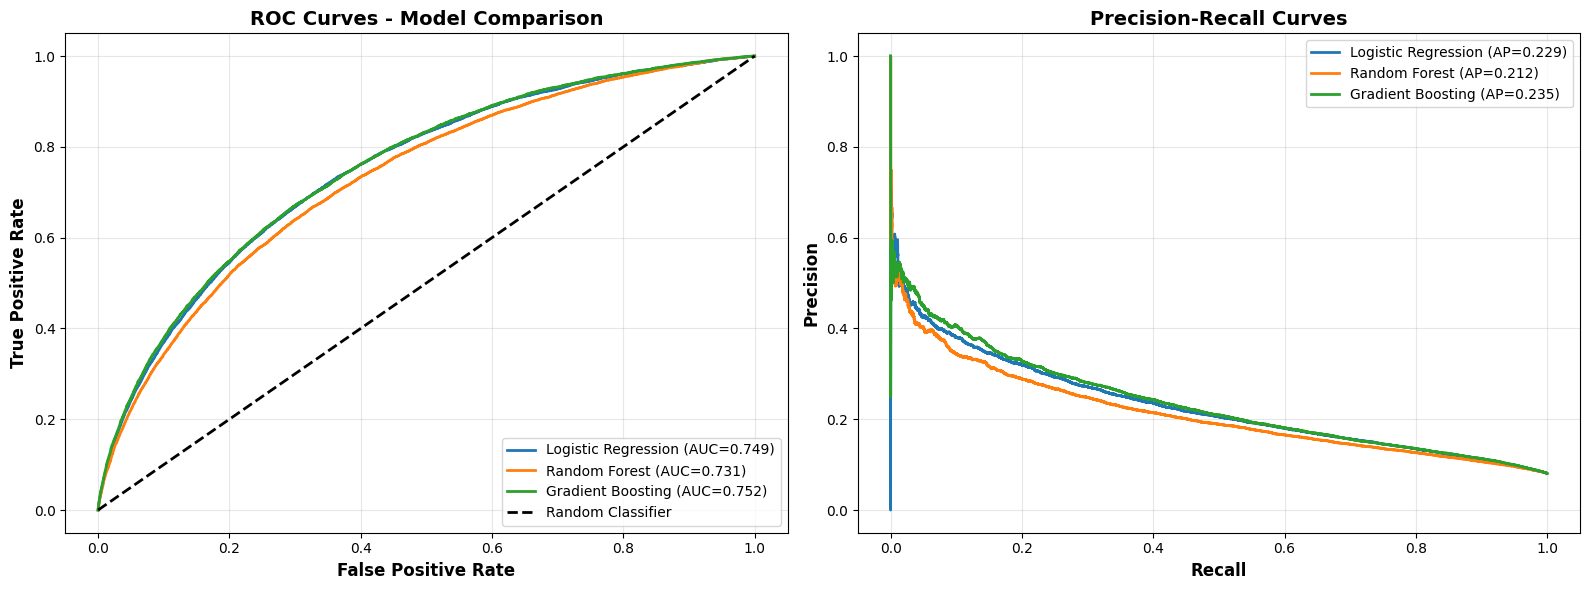

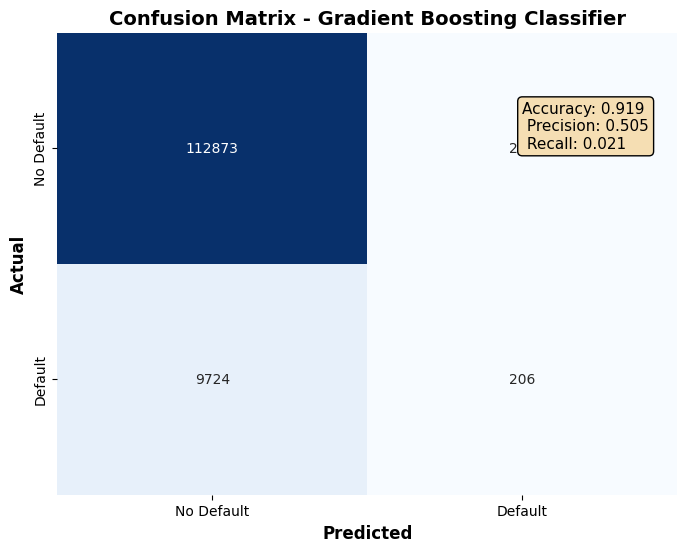

In [6]:
print("="* 60)
print("Credit Loss Forecasting Model Development")
print("="* 60)

def develop_credit_model(df, target_col = "TARGET"):
    """
    1: Logistic Regression (base line)
    2: Random Forest 
    3: Gradient Boosting 
    
    Evaluation metrics:
    - AUC-ROC 
    - Precision-Recall
    """
    
    # preparing data
    X = df.drop(columns = [target_col, "SK_ID_CURR"])
    y = df[target_col]
    
    # handling categorical variables
    categorical_cols = X.select_dtypes(include = ["object"]).columns
    
    X = pd.get_dummies(X, columns=categorical_cols)
    
    
    X = X.fillna(X.median())
    
    print(f"Features: {X.shape[1]}")
    print(f"Samples: {X.shape[0]}")
    print(f"Default rate: {y.mean():.2%}")
        
    
   
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    
    
    print(f"\n Training set: {X_train.shape[0]} samples ({y_train.mean():.2%} default rate)")
    print(f"\n Test set: {X_test.shape[0]} samples ({y_test.mean():.2%} default rate)")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n")
    print("="*60)
    print("Model 1: Logistic Regression")
    print("="*60)
    
    # model fitting
    
    lr_model = LogisticRegression(max_iter= 1000, random_state= 42, class_weight="balanced")
    lr_model.fit(X_train_scaled, y_train)
    
    # predictions
    y_pred_lr = lr_model.predict(X_test_scaled)
    y_prob_lr = lr_model.predict_proba(X_test_scaled)[:,1]
    
    # evaluation metrics
    auc_lr = roc_auc_score(y_test, y_prob_lr)
    
    print(f"\n AUC-ROC: {auc_lr:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred_lr, target_names = ["No Default", "Default"]))
    
    print("\n")
    print("="*60)
    print("Model 2: Random Forest")
    print("="*60)
    
    rf_model = RandomForestClassifier(
        n_estimators= 100,
        max_depth = 10,
        random_state= 42,
        class_weight = "balanced"
    )
    
    rf_model.fit(X_train, y_train)
    
    # predictions
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:,1]
    
    # evaluation metrics
    
    auc_rf = roc_auc_score(y_test, y_prob_rf)
    
    print(f"\n AUC-ROC: {auc_rf:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred_rf, target_names = ["No Default", "Default"]))
    
    
    # feature importance
    feature_importance = pd.DataFrame({
        "Feature": X.columns,
        "Importance": rf_model.feature_importances_
    }).sort_values("Importance", ascending= False)
    
    print("\n Top 20 Most Important Features")
    print(feature_importance.head(10).to_string())
    
    print("\n")
    print("="*60)
    print("Model 3: Gradient Boosting")
    print("="*60)
    
    gb_model = GradientBoostingClassifier(
        n_estimators= 100,
        learning_rate = 0.1,
        max_depth = 5,
        random_state= 42
    )
    
    gb_model.fit(X_train, y_train)
    
    # predictions
    y_pred_gb = gb_model.predict(X_test)
    y_prob_gb = gb_model.predict_proba(X_test)[:,1]
    
    # evaluation
    
    auc_gb = roc_auc_score(y_test, y_prob_gb)
    
    print(f"\n AUC-ROC: {auc_gb:.4f}")
    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred_gb, target_names= ["No Default", "Default"]))
    
    
    print("\n")
    print("="*60)
    print("Model Comparison")
    print("="*60)
    
    comparison = pd.DataFrame({
        "Model": ["Logistic Regression", "Random Forest Classifier", "Gradient Boosting Classifier"],
        "AUC-ROC": [auc_lr, auc_rf, auc_gb],
        "Average Precision": [
            average_precision_score(y_test, y_prob_lr),
            average_precision_score(y_test, y_prob_rf),
            average_precision_score(y_test, y_prob_gb)
        ]
    }).sort_values("AUC-ROC")
    
    print("\n" + comparison.to_string(index=False))
    
    print("\n Generating ROC Curves")
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    
    # ROC curve
    ax1 = axes[0]
    
    
    models = [
        ("Logistic Regression", y_prob_lr, auc_lr),
        ("Random Forest", y_prob_rf, auc_rf),
        ("Gradient Boosting", y_prob_gb, auc_gb)
    ]
    
    for name, y_prob, auc in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_prob)
        ax1.plot(false_positive_rate, true_positive_rate, linewidth= 2, label = f"{name} (AUC={auc:.3f})")

    ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(alpha=0.3)
    
    # Recall Curve
    ax2 = axes[1]
    
    for name, y_prob, _ in models:
        precision, recall, _= precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)
        ax2.plot(recall, precision, linewidth=2, label=f'{name} (AP={avg_precision:.3f})')
        
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    
    plt.tight_layout()
    print("ROC and Precision-Recall curves generated")
    
    # Confusion Matrix (Best Model)
    
    best_model_idx = comparison["AUC-ROC"].idxmax()
    best_model_name = comparison.loc[best_model_idx, "Model"]
    
    print(f"\n Best Model: {best_model_name}")
    
    if best_model_name == "Gradient Boosting Classifier":
        y_pred_best = y_pred_gb
    
    elif best_model_name == "Random Forest Classifier":
        y_pred_best = y_pred_rf 
    
    else:
        y_pred_best = y_pred_lr
    
    cm = confusion_matrix(y_test, y_pred_best)
    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
    ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    
    true_negative, false_positive, false_negative, true_positive = cm.ravel()
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    
    # out of all the predicted true labels, how many were actually true
    precision = true_positive / (true_positive + false_positive)
    
    # out of all the actual true labels, how many were actually true
    recall = true_positive / (true_positive + false_negative)
    
    metrics_text = f'Accuracy: {accuracy:.3f}\n Precision: {precision:.3f}\n Recall: {recall:.3f}'
    ax.text(1.5, 0.5, metrics_text, fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat'))
    print(" Confusion matrix generated")
    
    
    print("\n" + "-" * 60)
    print("Cross Validation analysis")
    print("-" * 60)
    
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, 
                                   scoring='roc_auc', n_jobs=-1)
    
    
    
    print(f"\nRandom Forest 5-Fold CV AUC-ROC:")
    print(f"Mean: {cv_scores_rf.mean():.4f}")
    print(f"Std:  {cv_scores_rf.std():.4f}")
    print(f"Scores: {[f'{s:.4f}' for s in cv_scores_rf]}")
    
    return {
        'models': {'lr': lr_model, 'rf': rf_model, 'gb': gb_model},
        'comparison': comparison,
        'feature_importance': feature_importance,
        'best_model': best_model_name
    }

df_engineered = pd.read_csv("/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/TensorFlow/CreditRisk/application_train_featured.csv")
results = develop_credit_model(df_engineered)

In [8]:
print(df_engineered["EXT_SOURCE_3"].unique())

[1.39375780e-01 5.35276250e-01 7.29566691e-01 6.21226338e-01
 4.92060094e-01 5.40654450e-01 7.51723715e-01 3.63945239e-01
 6.52896552e-01 1.76652579e-01 7.70087070e-01 6.78567689e-01
 6.21030378e-02 5.56727426e-01 4.77649155e-01 5.42445144e-01
 3.58951229e-01 6.69056695e-01 5.65607981e-01 4.61482391e-01
 1.90705948e-01 6.59405532e-01 5.24496446e-01 4.10102573e-01
 7.98137231e-01 4.11848556e-01 7.54406173e-01 7.22392890e-01
 6.05836265e-01 3.20163367e-01 3.99675616e-01 6.84827659e-01
 4.75849909e-01 7.28141299e-01 4.66864006e-01 4.79448981e-01
 3.09275356e-01 7.99296783e-01 7.01695774e-01 7.38019620e-01
 7.01088438e-02 1.69428727e-01 5.13693766e-01 7.07699345e-01
 3.39287700e-01 6.97146908e-01 4.34733249e-01 2.34015167e-01
 9.50703958e-02 5.62060483e-01 4.29423684e-01 4.13596760e-01
 8.32785025e-01 3.94495405e-01 5.97192427e-01 6.94092643e-01
 1.98620045e-01 1.91821602e-01 4.08358853e-01 4.52533559e-01
 7.20944150e-01 6.44679455e-01 3.42528872e-01 8.24594971e-01
 5.11891802e-01 6.413682